In [14]:
# prompt: Load dataset from Files section named 'Test Cat vs Noncat.h5'

import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Define utility functions

In [15]:
def load_data():
  train_dataset = h5py.File('/content/train_catvnoncat.h5', 'r')
  og_train_set_x = np.array(train_dataset['train_set_x'][:]) # Features
  og_train_set_y = np.array(train_dataset['train_set_y'][:]) # Labels

  test_dataset = h5py.File('/content/test_catvnoncat.h5', 'r')
  og_test_set_x = np.array(test_dataset['test_set_x'][:])
  og_test_set_y = np.array(test_dataset['test_set_y'][:])

  classes = np.array(train_dataset['list_classes'][:])

  og_train_set_y = og_train_set_y.reshape((1, og_train_set_y.shape[0]))
  og_test_set_y = og_test_set_y.reshape((1, og_test_set_y.shape[0]))

  return og_train_set_x, og_train_set_y, og_test_set_x, og_test_set_y, classes

def sigmoid(Z):
  A = (1/(1 + np.exp(-Z)))
  cache = A
  return A, cache


def relu(Z):
  A = np.maximum(0, Z)
  cache = A
  return A, cache


def initialize_parameters(layer_dims):
  L = len(layer_dims)
  parameters = {}

  for l in range(1, L):
    parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
    parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

  return parameters

###Forward

In [16]:
def linear_forward(A, W, b):
  Z = W.dot(A) + b
  cache = Z
  return Z, cache

def linear_activation_function(X, W, b, activation_function='relu'):
  Z, linear_cache = linear_forward(X, W, b)
  if activation_function == 'sigmoid':
    A, activation_cache = sigmoid(Z)
  if activation_function == 'relu':
    A, activation_cache = relu(Z)
  cache = (linear_cache, activation_cache)
  return A, cache


def forward_propagation(X, parameters): #calculate cache
  caches = []
  A = X
  L = len(parameters) // 2
  for l in range(1, L):
      prev_A = A
      A, cache = linear_activation_function(prev_A, parameters['W' + str(l)], parameters['b' + str(l)], activation_function='relu')
      caches.append(cache)

  AL, cache = linear_activation_function(A, parameters['W' + str(L)], parameters['b' + str(l)], activation_function='sigmoid')
  caches.append(cache)

  return AL, caches


def calculate_cost(AL, Y):
  m = AL.shape[1]
  J = (1/m) * (-np.dot(Y, np.log(AL).T) - np.dot((1-Y), np.log(1-AL).T))
  return np.squeeze(J)


###Back Prop

In [17]:
def relu_backwards(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backwards(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def linear_backwards(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = 1./m * np.dot(dZ,A_prev.T)
  db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)

  return dA_prev, dW, db


def linear_backward_activation_function(dA, cache, activation_function):
  linear_cache, activation_cache = cache
  if activation_function == 'sigmoid':
    dZ = sigmoid_backwards(dA, activation_cache)
    dA_prev, dW, db = linear_backwards(dZ, linear_cache)
  elif activation_function == 'relu':
    dZ = relu_backwards(dA, activation_cache)
    dA_prev, dW, db = linear_backwards(dZ, linear_cache)

  return dA_prev, dW, db


def backward_propagation(AL, Y, caches): #calculates gradients
  grads = []
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)

  cur_cache = caches[L-1]
  dAL = - (np.divide(Y, AL) - np.divide((1 - Y), (1 - AL)))
  grads['dA' + str(L)], grads['dW' + str(L)], grads['db' + str(L)] = linear_backward_activation_function(dAL, cur_cache, activation_function="sigmoid")

  for l in reversed(range(L-1)):
    cur_cache = caches[l]
    grads['dA' + str(l + 1)], grads['dW' + str(l + 1)], grads['db' + str(l + 1)] = linear_backward_activation_function('dA' + str(l + 2), cur_cache, activation_function="relu")

  return grads

def update_parameters(parameters, gradients, learning_rate=1.15):
  L = len(parameters) // 2
  for l in range(L):
    parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate * gradients['dW'+str(l+1)]
    parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate * gradients['db'+str(l+1)]
  return parameters

##Model

In [18]:
def nn_model(X, Y, layer_dims, learning_rate=1.2, iterations=1000, print_cost=False):
  np.random.seed(1)
  costs = []
  parameters = initialize_parameters(layer_dims)
  for i in range(0, iterations):
    AL, caches = forward_propagation(X, parameters)
    cost = calculate_cost(AL, Y)
    grads = backward_propagation(AL, Y, caches)
    parameters = update_parameters(parameters, grads, learning_rate)
    if print_cost and i % 1000 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)

  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations')
  plt.title('Learning Rate: ' + str(learning_rate))
  plt.show()
  return parameters


###Load Data

y = 1. It's a cat picture.


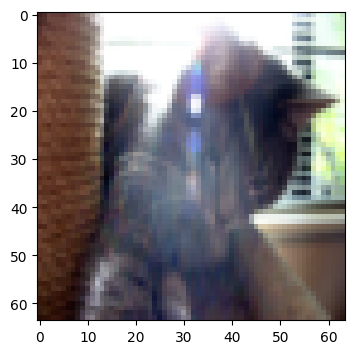

In [19]:
X_train, Y_train, X_test, Y_test, classes = load_data()
index = 42
plt.imshow(X_train[index])
print ("y = " + str(Y_train[0,index]) + ". It's a " + classes[Y_train[0,index]].decode("utf-8") +  " picture.")

##Trigger

In [20]:
# Reshape the training and test examples
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# print(X_train.shape)
layer_dims = [12288, 20, 7, 5, 1]

parameters = nn_model(X_train, Y_train, layer_dims, learning_rate=1.2, iterations=10000, print_cost=True)

(5, 209)
(1, 209)


ValueError: cannot reshape array of size 209 into shape (209,5)